# Multi-task training

In [1]:
!nvidia-smi

Sat Jan 15 21:59:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:3B:00.0 Off |                    0 |
| N/A   31C    P0    40W / 300W |      3MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
torch.cuda.empty_cache()

import gc
gc.collect()

0

Inspired by this notebook: https://colab.research.google.com/github/zphang/zphang.github.io/blob/master/files/notebooks/Multi_task_Training_with_Transformers_NLP.ipynb

Training works although we had a few problems:
- Quickly ran out of memory
- Couldn't load a model from the checkpoint

In [3]:
# import tensorflow as tf
# import torch
# print(tf.__version__)
# print(torch.__version__)
# !pip install pandas==1.1.4
# !pip install tensorflow==2.4.1
# !pip install torch==1.8.1

In [4]:
# import libraries and define utility functions
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict, ClassLabel, load_metric
import transformers
import torch.nn as nn
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer
import torch
import dataclasses
from torch.utils.data.dataloader import DataLoader
from transformers.data.data_collator import DataCollator, InputDataClass, DefaultDataCollator
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data.sampler import RandomSampler
from typing import List, Union, Dict
from sklearn.metrics import confusion_matrix



def create_datasets(tokenized_lyrics, feature, n=None, verbose=True, n_class=1, max_val=1):
    """
    n_class : if provided, quantize to this many classes with equal amount of per class
    n : to subset for testing purposes
    """
    lyrics_lab = tokenized_lyrics.copy()
    
    if feature == "genre":
        # already multiclass so different preparation
        labels_lst = sorted(list(set(df_clean["genre"])))
        labels = ClassLabel(names=labels_lst)
        lyrics_lab["train"] = lyrics_lab["train"].add_column("labels", labels.str2int(train["genre"]))
        lyrics_lab["validation"] = lyrics_lab["validation"].add_column("labels", labels.str2int(val["genre"]))
        lyrics_lab["test"] = lyrics_lab["test"].add_column("labels", labels.str2int(test["genre"]))

        # cast to ClassLabel
        for _key in lyrics_lab.keys():
            new_features = lyrics_lab[_key].features.copy()
            new_features["labels"] = labels
            lyrics_lab[_key] = lyrics_lab[_key].cast(new_features)
        
    else:
    
        if n_class > 1:
            edges = histedges_equalN(train[feature].values, n_class, max_val=max_val)
            if verbose:
                print(edges)
            lyrics_lab["train"] = lyrics_lab["train"].add_column("labels", quantize_feature(train[feature], edges))
            lyrics_lab["validation"] = lyrics_lab["validation"].add_column("labels", quantize_feature(val[feature], edges))
            lyrics_lab["test"] = lyrics_lab["test"].add_column("labels", quantize_feature(test[feature], edges))
        else:
            lyrics_lab["train"] = lyrics_lab["train"].add_column("labels", train[feature])
            lyrics_lab["validation"] = lyrics_lab["validation"].add_column("labels", val[feature])
            lyrics_lab["test"] = lyrics_lab["test"].add_column("labels", test[feature])
    
    if verbose:
        print(lyrics_lab)
    
    if n is not None:
        lyrics_lab["train"] = lyrics_lab["train"].shuffle(seed=seed).select(range(n)) 
        lyrics_lab["validation"] = lyrics_lab["validation"].shuffle(seed=seed).select(range(n)) 
        lyrics_lab["test"] = lyrics_lab["test"].shuffle(seed=seed).select(range(n)) 
    
    if verbose:
        print(lyrics_lab["train"])
        print(lyrics_lab["validation"])
        print(lyrics_lab["test"])
            
    return lyrics_lab


def quantize_feature(values, edges):
    labels = values.copy().astype(np.int)
    for i, _edge in enumerate(edges[:-1]):
        if i == 0:
            mask = values < edges[i+1]
        else:
            mask = np.logical_and(values >= edges[i], values < edges[i+1])
        labels[mask] = i
    return labels


def histedges_equalN(x, nbin, max_val=None):
    # https://stackoverflow.com/a/39419049
    npt = len(x)
    edges = np.interp(np.linspace(0, npt, nbin + 1), np.arange(npt), np.sort(x))
    if max_val:
        edges[-1] = max_val
    return edges

Our base model for fine-tuning.

In [5]:
# model_str = "sentence-transformers/all-mpnet-base-v2"    # 418 MB, 384 max length
model_str = "sentence-transformers/all-distilroberta-v1"   # 292 MB, 512 max length
# model_str = "sentence-transformers/all-MiniLM-L6-v2"       # 80 MB, 256 max length
# model_str = "sentence-transformers/all-MiniLM-L12-v2"       # 118 MB, 256 max length

tasks to fine-tune on and other parameters

In [8]:
tasks = ["genre", "valence"]
tasks = ["genre", "valence", "danceability"]
# tasks = ["genre", "valence", "danceability", "energy"]
freeze_base_model = False
n_class = 2
batch_size = 16
n_epochs = 5
n_example = None    # None to use everything
learning_rate = 1e-5   # default is 1e-3 for frozen base and 1e-5 otherwise

# 1) load and create datasets

In [9]:
# load original dataframe
df_clean = pd.read_pickle('df_clean_v4_14122021_py35.pkl')
print(df_clean.shape)
df_clean.head()

(15863, 17)


,lyrics,explicit,song_name,song_popularity,mode,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,release_year,artist,genre
song_id,,,,,,,,,,,,,,,,,
3e9HZxeyfWwjeyPAMmWSSQ,Thought I'd end up with Sean. But he wasn't a ...,1,"thank u, next",86,1,0.22900,0.717,0.653,0.000000,0.1010,-5.634,0.0658,0.412,106.966,2019,Ariana Grande,dance pop
5p7ujcrUXASCNwRaWNHR1C,Found you when your heart was broke. I filled ...,1,Without Me,87,1,0.29700,0.752,0.488,0.000009,0.0936,-7.050,0.0705,0.533,136.041,2018,Halsey,dance pop
2xLMifQCjDGFmkHkpNLD9h,"Astro, yeah. Sun is down, freezin' cold. That'...",1,SICKO MODE,85,1,0.00513,0.834,0.730,0.000000,0.1240,-3.714,0.2220,0.446,155.008,2018,Travis Scott,hip-hop/rap
1rqqCSm0Qe4I9rUvWncaom,"High, high hopes. Had to have high, high hopes...",0,High Hopes,86,1,0.19300,0.579,0.904,0.000000,0.0640,-2.729,0.0618,0.681,82.014,2018,Panic! At The Disco,rock
0bYg9bo50gSsH3LtXe2SQn,I-I-I don't want a lot for Christmas. There is...,0,All I Want for Christmas Is You,63,1,0.16400,0.335,0.625,0.000000,0.0708,-7.462,0.0386,0.346,150.277,1994,Mariah Carey,dance pop


In [10]:
# train, validation, test split
seed = 11
val_size = 0.15
test_size = 0.15
train, _eval = train_test_split(
    df_clean, test_size=val_size + test_size, random_state=seed, stratify=df_clean['genre']
)
val, test = train_test_split(
    _eval, test_size=test_size / (val_size + test_size), random_state=seed, stratify=_eval['genre']
)
print(train.shape)
print(val.shape)
print(test.shape)

(11104, 17)
(2379, 17)
(2380, 17)


In [11]:
# create a DatasetDict as expected by Hugging Face
lyrics = DatasetDict()

# arguments expected by forward: https://github.com/huggingface/transformers/blob/9aeacb58bab321bc21c24bbdf7a24efdccb1d426/src/transformers/modeling_bert.py#L1313
lyrics["train"] = Dataset.from_dict({"text": list(train["lyrics"])})
lyrics["validation"] = Dataset.from_dict({"text": list(val["lyrics"])})
lyrics["test"] = Dataset.from_dict({"text": list(test["lyrics"])})

print(lyrics)

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 11104
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 2379
    })
    test: Dataset({
        features: ['text'],
        num_rows: 2380
    })
})


In [12]:
# tokenize
tokenizer = AutoTokenizer.from_pretrained(model_str, use_fast=True)
    
def preprocess_function(examples):
    return tokenizer(examples["text"], padding=True, truncation=True)

tokenized_lyrics = lyrics.map(preprocess_function, batched=True)

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

In [13]:
# create dataset for different metadata
genre_dataset = create_datasets(tokenized_lyrics, feature="genre", verbose=False)
valence_dataset = create_datasets(tokenized_lyrics, feature="valence", n_class=n_class, verbose=False)
danceability_dataset = create_datasets(tokenized_lyrics, feature="danceability", n_class=n_class, verbose=False)
energy_dataset = create_datasets(tokenized_lyrics, feature="energy", n_class=n_class, verbose=False)

labels_lst = sorted(list(set(df_clean["genre"])))
labels = ClassLabel(names=labels_lst)

# print one example and its outputs
_id = 1
print(f"{train.iloc[_id]['song_name']} by {train.iloc[_id]['artist']}\n")
print(f"Lyrics : {valence_dataset['train'][_id]['text'][:300]}")
print(f"Genre : {labels.int2str(genre_dataset['train'][_id]['labels'])}")
print(f"Valence : {valence_dataset['train'][_id]['labels']}")
print(f"Danceability : {danceability_dataset['train'][_id]['labels']}")
print(f"Energy : {energy_dataset['train'][_id]['labels']}")


Casting the dataset:   0%|          | 0/2 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

I Could Never Be Happy by The Emotions

Lyrics : Yeah, hey. Ahh, mmm. You're my life when shadows fall. You're my hope when faith is lost. You're my shelter from the storms. When winter's cold, you keep me warm. (Keep me warm). Life was just an empty dream. Until your love captured me. (Captured me). And if I should lose your tender touch. I would
Genre : r&b
Valence : 0
Danceability : 0
Energy : 0


create dataset and prepare features for the tasks we are interested in

In [14]:
dataset_dict = dict()
columns_dict = dict()
for _task in tasks:
    dataset_dict[_task] = create_datasets(
        tokenized_lyrics, feature=_task, n_class=n_class, n=n_example, verbose=False)
    columns_dict[_task] = ['input_ids', 'attention_mask', 'labels']
    
    
features_dict = {}
for task_name, dataset in dataset_dict.items():
    features_dict[task_name] = {}
    for phase, phase_dataset in dataset.items():
        features_dict[task_name][phase] = phase_dataset
        print(task_name, phase, len(phase_dataset), len(features_dict[task_name][phase]))
        features_dict[task_name][phase].set_format(
            type="torch", 
            columns=columns_dict[task_name],
        )
        print(task_name, phase, len(phase_dataset), len(features_dict[task_name][phase]))

Casting the dataset:   0%|          | 0/2 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

genre train 11104 11104
genre train 11104 11104
genre validation 2379 2379
genre validation 2379 2379
genre test 2380 2380
genre test 2380 2380
valence train 11104 11104
valence train 11104 11104
valence validation 2379 2379
valence validation 2379 2379
valence test 2380 2380
valence test 2380 2380
danceability train 11104 11104
danceability train 11104 11104
danceability validation 2379 2379
danceability validation 2379 2379
danceability test 2380 2380
danceability test 2380 2380


# 2) create multitask model

In [15]:
class MultitaskModel(transformers.PreTrainedModel):
    def __init__(self, encoder, taskmodels_dict, freeze_base_model=False):
        """
        Setting MultitaskModel up as a PretrainedModel allows us
        to take better advantage of Trainer features
        """
        super().__init__(transformers.PretrainedConfig())

        self.encoder = encoder
#         if freeze_base_model:
#             self.freeze_encoder()
        if freeze_base_model:
            for name, param in encoder.named_parameters():
                if 'classifier' not in name: # classifier layer
                    param.requires_grad = False
        self.taskmodels_dict = nn.ModuleDict(taskmodels_dict)

    @classmethod
    def create(cls, model_name, model_type_dict, model_config_dict, freeze_base_model=False):
        """
        This creates a MultitaskModel using the model class and config objects
        from single-task models. 

        We do this by creating each single-task model, and having them share
        the same encoder transformer.
        """
        shared_encoder = None
        taskmodels_dict = {}
        for task_name, model_type in model_type_dict.items():
            model = model_type.from_pretrained(
                model_name, 
                config=model_config_dict[task_name],
            )
            if shared_encoder is None:
                shared_encoder = getattr(model, cls.get_encoder_attr_name(model))
            else:
                setattr(model, cls.get_encoder_attr_name(model), shared_encoder)
            taskmodels_dict[task_name] = model
        return cls(encoder=shared_encoder, taskmodels_dict=taskmodels_dict, freeze_base_model=freeze_base_model)

    @classmethod
    def get_encoder_attr_name(cls, model):
        """
        The encoder transformer is named differently in each model "architecture".
        This method lets us get the name of the encoder attribute
        """
        model_class_name = model.__class__.__name__
        print(model_class_name)
        if model_class_name.startswith("Bert"):
            return "bert"
        elif model_class_name.startswith("Roberta"):
            return "roberta"
        elif model_class_name.startswith("Albert"):
            return "albert"
        elif model_class_name.startswith("MPNet"):
            return "mpnet"
        else:
            raise KeyError(f"Add support for new model {model_class_name}")

    def forward(self, task_name, **kwargs):
        return self.taskmodels_dict[task_name](**kwargs)
    
    def unfreeze_encoder(self):
        for name, param in self.encoder.named_parameters():
            if 'classifier' not in name:
                param.requires_grad = True
        
    def freeze_encoder(self):
        for name, param in self.encoder.named_parameters():
            if 'classifier' not in name:
                param.requires_grad = False
        
    
    
model_type_dict = dict()
model_config_dict = dict()
for _task in tasks:
    model_type_dict[_task] = transformers.AutoModelForSequenceClassification
    model_config_dict[_task] = transformers.AutoConfig.from_pretrained(
        model_str, num_labels=n_class if _task != "genre" else len(list(set(df_clean["genre"])))
    )
multitask_model = MultitaskModel.create(
    model_name=model_str,
    model_type_dict=model_type_dict,
    model_config_dict=model_config_dict,
    freeze_base_model=freeze_base_model
)

Some weights of the model checkpoint at sentence-transformers/all-distilroberta-v1 were not used when initializing RobertaForSequenceClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/all-distilroberta-v1 and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN t

RobertaForSequenceClassification


Some weights of the model checkpoint at sentence-transformers/all-distilroberta-v1 were not used when initializing RobertaForSequenceClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/all-distilroberta-v1 and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN t

RobertaForSequenceClassification


Some weights of the model checkpoint at sentence-transformers/all-distilroberta-v1 were not used when initializing RobertaForSequenceClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/all-distilroberta-v1 and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN t

RobertaForSequenceClassification


In [16]:
# check use same encoder
if "mpnet" in model_str:
    print(multitask_model.encoder.embeddings.word_embeddings.weight.data_ptr())
    for _key in multitask_model.taskmodels_dict.keys():
        print(multitask_model.taskmodels_dict[_key].mpnet.embeddings.word_embeddings.weight.data_ptr())
elif "roberta" in model_str:
    print(multitask_model.encoder.embeddings.word_embeddings.weight.data_ptr())
    for _key in multitask_model.taskmodels_dict.keys():
        print(multitask_model.taskmodels_dict[_key].roberta.embeddings.word_embeddings.weight.data_ptr())
else:
    print("no model")

139934366117952
139934366117952
139934366117952
139934366117952


In [17]:
# check frozen/unfrozen
for name, param in multitask_model.encoder.named_parameters():
    print(name, param.requires_grad)

embeddings.word_embeddings.weight True
embeddings.position_embeddings.weight True
embeddings.token_type_embeddings.weight True
embeddings.LayerNorm.weight True
embeddings.LayerNorm.bias True
encoder.layer.0.attention.self.query.weight True
encoder.layer.0.attention.self.query.bias True
encoder.layer.0.attention.self.key.weight True
encoder.layer.0.attention.self.key.bias True
encoder.layer.0.attention.self.value.weight True
encoder.layer.0.attention.self.value.bias True
encoder.layer.0.attention.output.dense.weight True
encoder.layer.0.attention.output.dense.bias True
encoder.layer.0.attention.output.LayerNorm.weight True
encoder.layer.0.attention.output.LayerNorm.bias True
encoder.layer.0.intermediate.dense.weight True
encoder.layer.0.intermediate.dense.bias True
encoder.layer.0.output.dense.weight True
encoder.layer.0.output.dense.bias True
encoder.layer.0.output.LayerNorm.weight True
encoder.layer.0.output.LayerNorm.bias True
encoder.layer.1.attention.self.query.weight True
encoder.

# 3) preparing multi-task data loader
https://github.com/huggingface/transformers/blob/master/src/transformers/data/data_collator.py

In [18]:
class NLPDataCollator(DefaultDataCollator):
    """
    Extending the existing DataCollator to work with NLP dataset batches
    """
    def collate_batch(self, features):
        first = features[0]
        if isinstance(first, dict):
            # NLP data sets current works presents features as lists of dictionary
            # (one per example), so we  will adapt the collate_batch logic for that
            if "labels" in first and first["labels"] is not None:
                if first["labels"].dtype == torch.int64:
                    labels = torch.tensor([f["labels"] for f in features], dtype=torch.long)
                else:
                    labels = torch.tensor([f["labels"] for f in features], dtype=torch.float)
                batch = {"labels": labels}
            for k, v in first.items():
                if k != "labels" and v is not None and not isinstance(v, str):
                    batch[k] = torch.stack([f[k] for f in features])
            return batch
        else:
            # otherwise, revert to using the default collate_batch
            return DefaultDataCollator().collate_batch(features)


class StrIgnoreDevice(str):
    """
    This is a hack. The Trainer is going call .to(device) on every input
    value, but we need to pass in an additional `task_name` string.
    This prevents it from throwing an error
    """
    def to(self, device):
        return self


class DataLoaderWithTaskname:
    """
    Wrapper around a DataLoader to also yield a task name
    """
    def __init__(self, task_name, data_loader):
        self.task_name = task_name
        self.data_loader = data_loader

        self.batch_size = data_loader.batch_size
        self.dataset = data_loader.dataset

    def __len__(self):
        return len(self.data_loader)
    
    def __iter__(self):
        for batch in self.data_loader:
            batch["task_name"] = StrIgnoreDevice(self.task_name)
            yield batch


class MultitaskDataloader:
    """
    Data loader that combines and samples from multiple single-task
    data loaders.
    """
    def __init__(self, dataloader_dict, batch_size=None):
        self.dataloader_dict = dataloader_dict
        self.num_batches_dict = {
            task_name: len(dataloader) 
            for task_name, dataloader in self.dataloader_dict.items()
        }
        self.task_name_list = list(self.dataloader_dict)
        self.dataset = [None] * sum(
            len(dataloader.dataset) 
            for dataloader in self.dataloader_dict.values()
        )
        self.batch_size = batch_size

    def __len__(self):
        return sum(self.num_batches_dict.values())

    def __iter__(self):
        """
        For each batch, sample a task, and yield a batch from the respective
        task Dataloader.

        We use size-proportional sampling, but you could easily modify this
        to sample from some-other distribution.
        """
        task_choice_list = []
        for i, task_name in enumerate(self.task_name_list):
            task_choice_list += [i] * self.num_batches_dict[task_name]
        task_choice_list = np.array(task_choice_list)
        np.random.shuffle(task_choice_list)
        dataloader_iter_dict = {
            task_name: iter(dataloader) 
            for task_name, dataloader in self.dataloader_dict.items()
        }
        for task_choice in task_choice_list:
            task_name = self.task_name_list[task_choice]
            yield next(dataloader_iter_dict[task_name])  

# 4) preparing multi-task Trainer

remove TPU code snippets

In [19]:
class MultitaskTrainer(transformers.Trainer):

    def get_single_train_dataloader(self, task_name, train_dataset):
        """
        Create a single-task data loader that also yields task names
        """
        if self.train_dataset is None:
            raise ValueError("Trainer: training requires a train_dataset.")
#         train_sampler = self._get_train_sampler()
        train_sampler = (
            RandomSampler(train_dataset)
            if self.args.local_rank == -1
            else DistributedSampler(train_dataset)
        )

        data_loader = DataLoaderWithTaskname(
            task_name=task_name,
            data_loader=DataLoader(
              train_dataset,
              batch_size=self.args.train_batch_size,
              sampler=train_sampler,
              collate_fn=self.data_collator.collate_batch,
            ),
        )
        return data_loader

    def get_train_dataloader(self):
        """
        Returns a MultitaskDataloader, which is not actually a Dataloader
        but an iterable that returns a generator that samples from each 
        task Dataloader
        """
        return MultitaskDataloader({
            task_name: self.get_single_train_dataloader(task_name, task_dataset)
            for task_name, task_dataset in self.train_dataset.items()
        }, batch_size=self.args.train_batch_size)
    
    
    def get_single_eval_dataloader(self, task_name, eval_dataset):
        """
        Create a single-task data loader that also yields task names
        """
        if self.eval_dataset is None:
            raise ValueError("Trainer: validation requires a eval_dataset.")
        eval_sampler = self._get_eval_sampler(eval_dataset)

        data_loader = DataLoaderWithTaskname(
            task_name=task_name,
            data_loader=DataLoader(
              eval_dataset,
              batch_size=self.args.eval_batch_size,
              sampler=eval_sampler,
              collate_fn=self.data_collator.collate_batch,
            ),
        )
        return data_loader

    def get_eval_dataloader(self, eval_dataset=None):
        """
        Returns a MultitaskDataloader, which is not actually a Dataloader
        but an iterable that returns a generator that samples from each 
        task Dataloader
        """
        return MultitaskDataloader({
            task_name: self.get_single_eval_dataloader(task_name, task_dataset)
            for task_name, task_dataset in self.eval_dataset.items()
        }, batch_size=self.args.eval_batch_size)

# 5) Train!

In [20]:
# learning_rate = 1e-3
output_dir = os.path.basename(model_str) + "_finetuned_multitask_" + "_".join(tasks)
if freeze_base_model:
    if learning_rate is None:
        learning_rate = 1e-3
    output_dir += "_frozen_base"
#     multitask_model.freeze_encoder()
else:
    if learning_rate is None:
        learning_rate = 1e-5
#     multitask_model.unfreeze_encoder()
if n_example:
    output_dir += f"_{n_example}"
lr_str = str(learning_rate).replace(".", "p")
output_dir += f"_{lr_str}"

print(learning_rate)
print(output_dir)

1e-05
all-distilroberta-v1_finetuned_multitask_genre_valence_danceability_1e-05


fine-tuning just classification heads to first learn some good classifiers and then fine-tune everything with small learning rate

In [21]:
train_dataset = {
    task_name: dataset["train"] 
    for task_name, dataset in dataset_dict.items()
}
eval_dataset = {
    task_name: dataset["validation"] 
    for task_name, dataset in dataset_dict.items()
}
metric = load_metric("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

trainer = MultitaskTrainer(
    model=multitask_model,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        overwrite_output_dir=True,
        learning_rate=learning_rate,
        do_train=True,
        num_train_epochs=n_epochs,
        per_device_train_batch_size=batch_size,  
        per_device_eval_batch_size=batch_size,
        save_steps=3000,
        # from fine-tuning notebook
        weight_decay=0.01,
        evaluation_strategy = "epoch",
        save_strategy = "epoch",
        load_best_model_at_end=True,
        metric_for_best_model="accuracy"
    ),
    data_collator=NLPDataCollator(),
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()
# trainer.train(resume_from_checkpoint=True)   # reload model

***** Running training *****
  Num examples = 33312
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 10410


Epoch,Training Loss,Validation Loss,Accuracy
1,0.907100,0.914085,0.581197


***** Running Evaluation *****
  Num examples = 7137
  Batch size = 16
Saving model checkpoint to all-distilroberta-v1_finetuned_multitask_genre_valence_danceability_1e-05/checkpoint-2082
Configuration saved in all-distilroberta-v1_finetuned_multitask_genre_valence_danceability_1e-05/checkpoint-2082/config.json
Model weights saved in all-distilroberta-v1_finetuned_multitask_genre_valence_danceability_1e-05/checkpoint-2082/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 7137
  Batch size = 16


In [87]:
preds_dict = {}
for _task in tasks:
    test_dataloader = trainer.get_single_eval_dataloader(
        _task,
        eval_dataset=features_dict[_task]["test"]
    )
    preds_dict[_task] = trainer.prediction_loop(
        test_dataloader, 
        description=f"Test: {_task}",
    )

***** Running Test: genre *****
  Num examples = 7932
  Batch size = 32
/usr/local/lib/python3.6/dist-packages/transformers/trainer_pt_utils.py:382: FutureWarning: DistributedTensorGatherer is deprecated and will be removed in v5 of Transformers.
  FutureWarning,


***** Running Test: valence *****
  Num examples = 7932
  Batch size = 32



genre
['0 - acoustic/folk', '1 - country', '2 - dance pop', '3 - hip-hop/rap', '4 - pop', '5 - r&b', '6 - rock', '7 - soul/disco']

valence


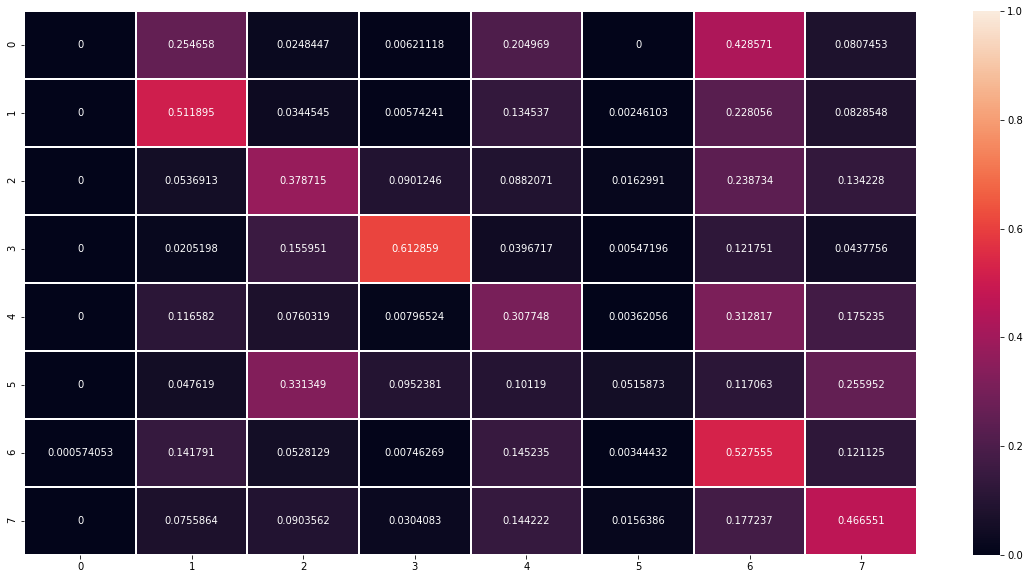

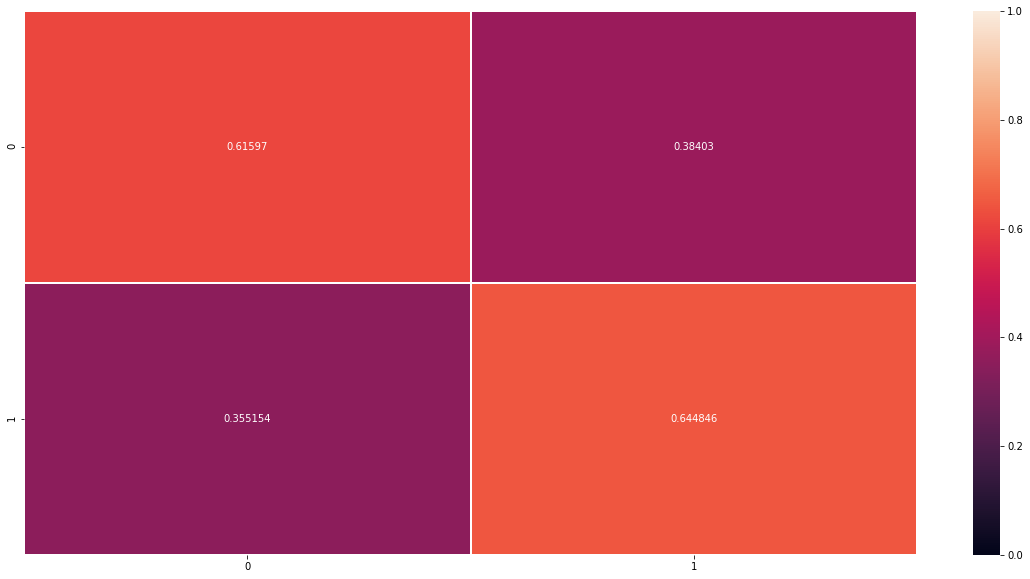

In [88]:
normalize = True

for _task in tasks:
    
    print(f"\n{_task}")

    predictions = np.argmax(preds_dict[_task].predictions, axis=-1)
    true_vals = preds_dict[_task].label_ids
    cf_matrix = confusion_matrix(true_vals, predictions, normalize="true" if normalize else None)
    fig, ax = plt.subplots(figsize=(20,10)) 
    if normalize:
        sns.heatmap(cf_matrix, linewidths=1, annot=True, ax=ax, fmt='g', vmin=0, vmax=1)
    else:
        sns.heatmap(cf_matrix, linewidths=1, annot=True, ax=ax, fmt='g')
    if _task == "genre":
        print([f"{i} - {lab}" for i, lab in enumerate(labels.names)])